# Capstone Project: Inventory Monitoring at Distribution Centers

Knowing exactly the count of a physical inventory has been a key issue in all industries that are involved in manufacturing and retail processes. Historically, this is a job that warehouse managers and supply chain professionals have performed through cycle counting, an audit process for managing inventory counts.

In this notebook, a solution for object counting is presented. The solution uses the Pytorch framework available from AWS SageMaker. The goal is to deploy a SageMaker endpoint that will query images to get predictions about the number of objects in the submitted image.

In [1]:
# Install libraries required
!pip install smdebug
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
# Import libraries and packages

from tqdm import tqdm
import sagemaker

from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

role = sagemaker.get_execution_role()

## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. 

In [3]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

In [4]:
download_and_arrange_data()

100%|██████████| 1228/1228 [01:34<00:00, 12.95it/s]


100%|██████████| 2299/2299 [03:05<00:00, 12.39it/s]


100%|██████████| 2666/2666 [03:42<00:00, 11.97it/s]


100%|██████████| 2373/2373 [03:17<00:00, 11.99it/s]


100%|██████████| 1875/1875 [02:30<00:00, 12.47it/s]


## Dataset

For this project, a small subset of the [Amazon Bin Image Dataset](https://registry.opendata.aws/amazon-bin-imagery/) is used . The original dataset contains over 500.000 container images and metadata from a pod in a working Amazon fulfillment center. The subset is made up of 10.441 images with the following class distribution:

"1" : 1228 images  
"2" : 2299 images  
"3" : 2666 images  
"4" : 2373 images  
"5" : 1875 images  

"i" denotes the number of objects that are present in the bin of the image. In order to prepare the data for the training process the data was splitted in traing and test sets, 80% of data for training and 20% for testing. Both sets were stored in their respective S3 buckets.

In [47]:
import shutil
import random

os.makedirs("train")
os.makedirs("test")

for i in range(1,6):
    sf_path = os.path.join("train_data", str(i))
    train_sf = os.path.join("train", str(i))
    test_sf = os.path.join("test", str(i))
    os.makedirs(train_sf)
    os.makedirs(test_sf)

    images = []
    for image in os.listdir(sf_path):
        images.append(image)
        random.shuffle(images)
        train_images = images[:int(0.8 * len(images))]
        test_images = images[int(0.8 * len(images)):]

    for train_image in train_images:
        if train_image.endswith('.jpg'):
            src = os.path.join(sf_path, train_image)
            dst = os.path.join(train_sf, train_image)
            shutil.copy(src, dst)

    for test_image in test_images:
        if train_image.endswith('.jpg'):
            src = os.path.join(sf_path, test_image)
            dst = os.path.join(test_sf, test_image)
            shutil.copy(src, dst)

In [49]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix1 = "sagemaker/Final-Project/train"
prefix2 = "sagemaker/Final-Project/test"

train = sagemaker_session.upload_data(path="train", bucket=bucket, key_prefix=prefix1)
print("train: {}".format(train))

test = sagemaker_session.upload_data(path="test", bucket=bucket, key_prefix=prefix2)
print("test: {}".format(test))

train: s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/train
test: s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/test


## Model Training

The first model was trained with fixed hyperparameters, without hyperparameter tunning

In [17]:
hyperparameters = {
            "epochs": "1", 
            "batch-size": "64", 
            "lr": "0.05"
}

In [18]:
estimator = PyTorch(
    entry_point="train.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [19]:
estimator.fit(
    {
        "train":"s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/train/",
        "test":"s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/test/",
    }
) 

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-07-03-02-08-33-026


Using provided s3_resource
2023-07-03 02:08:33 Starting - Starting the training job...
2023-07-03 02:08:49 Starting - Preparing the instances for training......
2023-07-03 02:09:59 Downloading - Downloading input data......
2023-07-03 02:10:35 Training - Downloading the training image..................
2023-07-03 02:14:06 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-03 02:14:17,525 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-07-03 02:14:17,554 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-03 02:14:17,557 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-07-03 02:14:17,860 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": 

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [5]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.01, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "epochs": IntegerParameter(1, 10),
}

In [8]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([-3000-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [ ]:
tuner.fit(
          {
            "train":"s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/train/",
            "test":"s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/test/",
          }
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230627-0059


.....................................................................................................................................................................................................................................................................................................................!


In [10]:
best_estimator = tuner.best_estimator()
best_estimator.hyperparameters()


2023-06-27 01:25:51 Starting - Found matching resource for reuse
2023-06-27 01:25:51 Downloading - Downloading input data
2023-06-27 01:25:51 Training - Training image download completed. Training in progress.
2023-06-27 01:25:51 Uploading - Uploading generated training model
2023-06-27 01:25:51 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'epochs': '10',
 'lr': '0.019560250886627155',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-06-27-00-59-33-568"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-553171274417/pytorch-training-2023-06-27-00-59-33-568/source/sourcedir.tar.gz"'}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [2]:
# TODO: Set up debugging and profiling rules and hooks

from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)

from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "1"}
)

collection_configs=[
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "10",
            "eval.save_interval": "1"
        }
      )
    ]

hook_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [11]:
# TODO: Create and fit an estimator
hyperparameters = {"epochs": "10", "batch-size": "32", "lr": "0.019560250886627155"}

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="smdebugger-final-pytorch",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [13]:
estimator.fit(
          {
            "train":"s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/train/",
            "test":"s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/test/",
          }
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: smdebugger-final-pytorch-2023-07-01-23-18-12-601


Using provided s3_resource
2023-07-01 23:18:12 Starting - Starting the training job...
2023-07-01 23:18:39 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-07-01 23:19:39 Downloading - Downloading input data.........
2023-07-01 23:21:05 Training - Downloading the training image...............
2023-07-01 23:23:40 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-01 23:23:42,714 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-07-01 23:23:42,740 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-01 23:23:42,744 sagemaker_pytorch_container.training INFO    

In [14]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [15]:
job_name

'smdebugger-final-pytorch-2023-07-01-23-18-12-601'

In [17]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-07-01 23:41:51.545 ip-172-16-102-21.ec2.internal:9031 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-553171274417/smdebugger-final-pytorch-2023-07-01-23-18-12-601/debug-output
[2023-07-01 23:41:52.132 ip-172-16-102-21.ec2.internal:9031 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 233 more expected)', IncompleteRead(0 bytes read, 233 more expected)) while reading s3://sagemaker-us-east-1-553171274417/smdebugger-final-pytorch-2023-07-01-23-18-12-601/debug-output/index/000000000/000000000292_worker_0.json . Will retry now


In [18]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

[2023-07-01 23:42:07.863 ip-172-16-102-21.ec2.internal:9031 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-07-01 23:42:08.901 ip-172-16-102-21.ec2.internal:9031 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


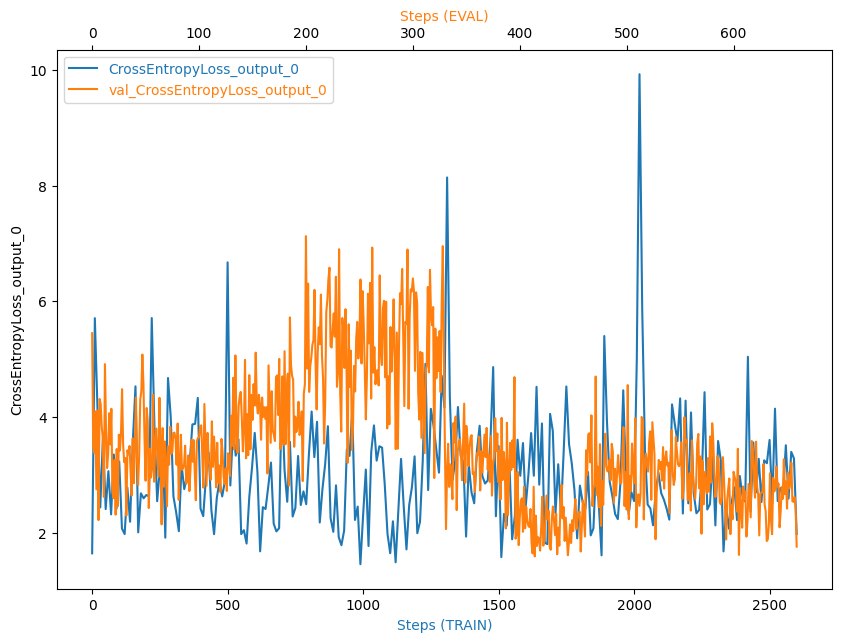

In [20]:
# TODO: Display the profiler output
plot_tensor(trial, "CrossEntropyLoss_output_0")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [13]:
# TODO: Deploy your model to an endpoint
from sagemaker.pytorch.model import PyTorchModel

pytorch_model = PyTorchModel(framework_version=estimator.framework_version,
                             py_version=estimator.py_version,
                             model_data=estimator.model_data, 
                             role=role, 
                             entry_point='deployment.py')


predictor = pytorch_model.deploy(initial_instance_count=1,instance_type='ml.g4dn.xlarge') # TODO: Add your deployment configuration like instance type and number of instances


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-553171274417/smdebugger-final-pytorch-2023-06-28-21-17-00-587/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-553171274417/pytorch-inference-2023-06-28-21-44-56-473/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-06-28-21-45-05-693
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-06-28-21-45-06-413
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-06-28-21-45-06-413


---------!

In [ ]:
# TODO: Run an prediction on the endpoint


In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances